# USA PPA

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [6]:
in_file = os.path.join('..','in','datacenters_usa_clean.csv')
#dc_df = datacenter_dataframe
dc_df = pd.read_csv(in_file)

# Remove inplace=True
dc_df.drop(['postal', 'link_profile', 'geometry'], axis=1, inplace=True)

# Create a GeoDataFrame
dc_gdf = gpd.GeoDataFrame(dc_df, geometry=gpd.points_from_xy(dc_df.longitude, dc_df.latitude))

# Define or identify the coordinate reference system (CRS)
# For the United States, you can use EPSG:4326 (WGS 84) which is commonly used for latitude and longitude coordinates
dc_gdf.crs = "EPSG:4326"

# create a version without hawaii
dc_gdf_filtered = dc_gdf[dc_gdf['state'] != 'Hawaii']

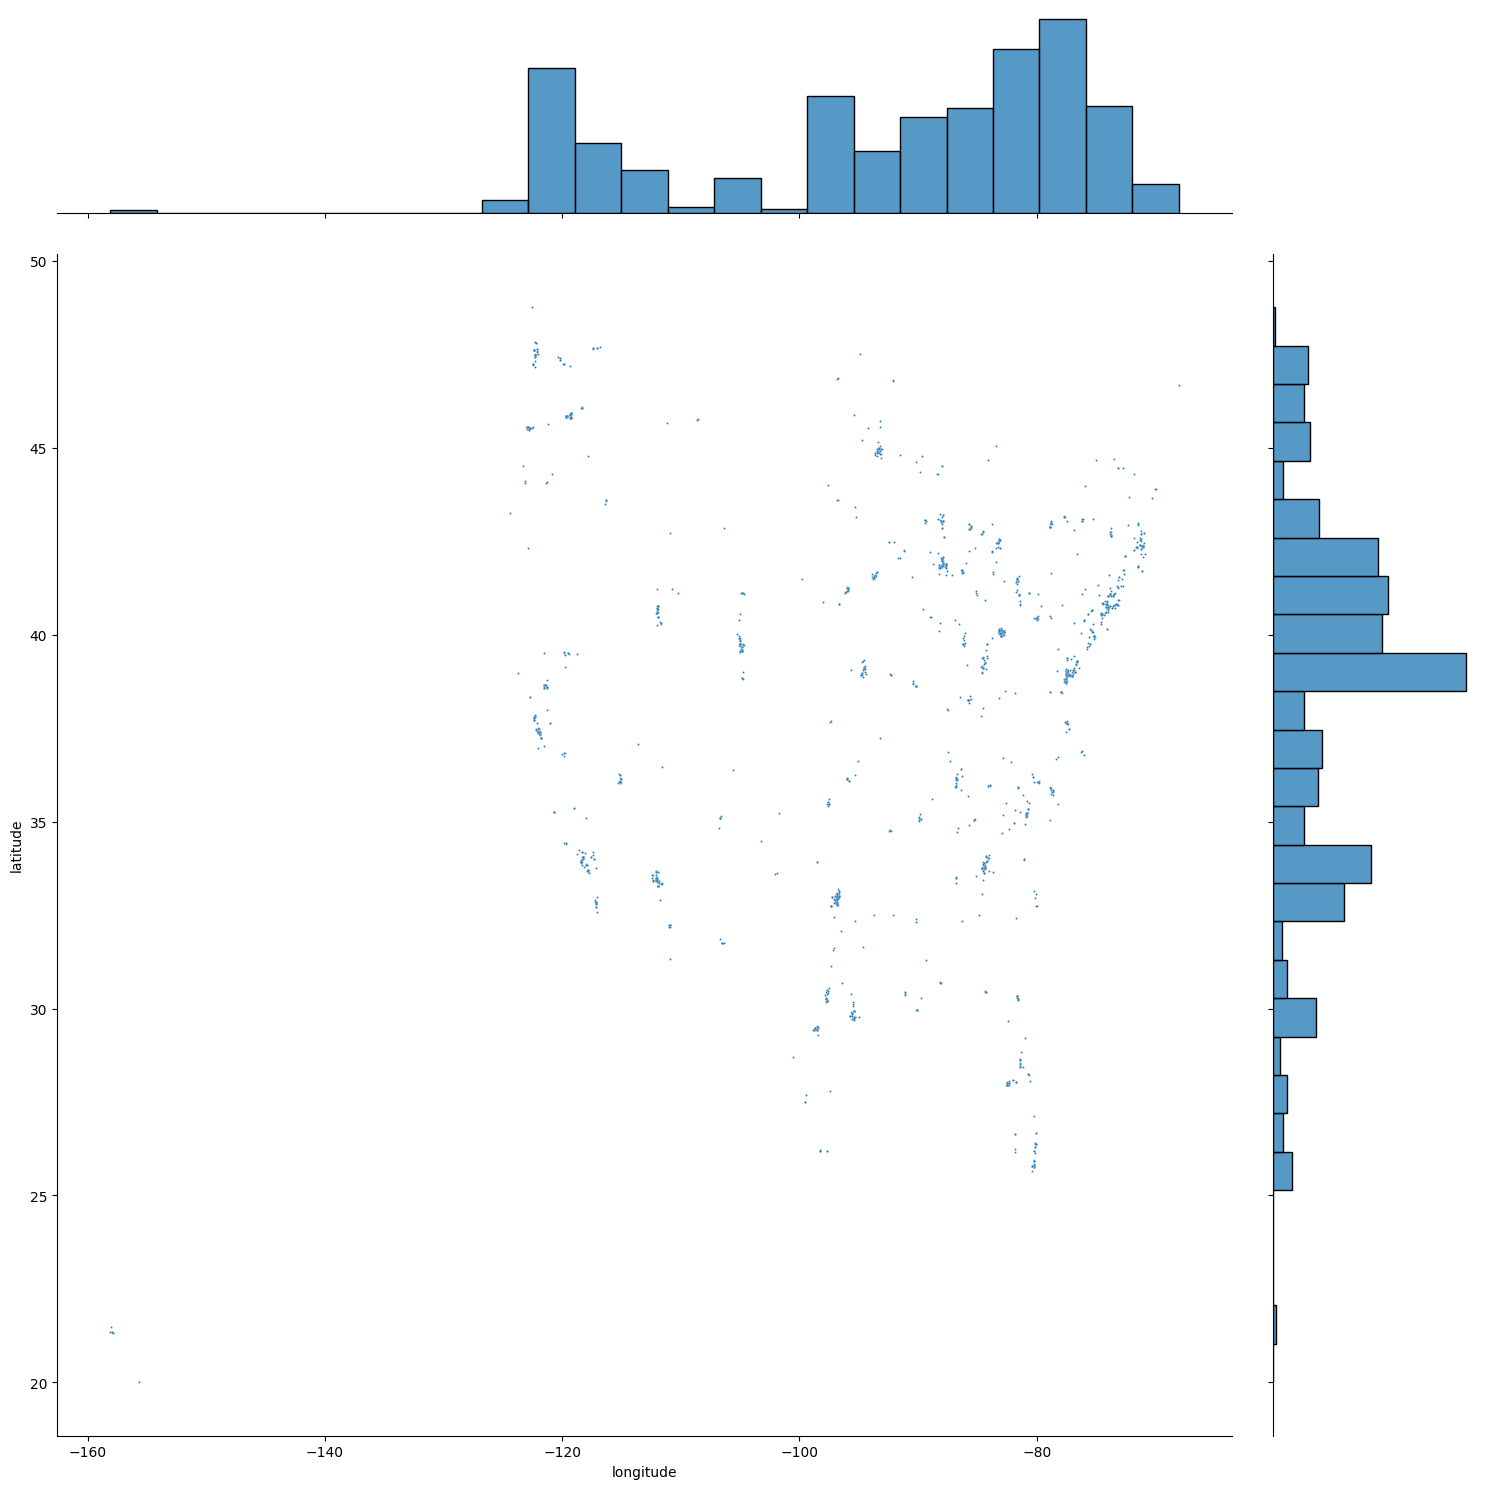

In [7]:
# Generate scatter plot
seaborn.jointplot(height=15, x="longitude", y="latitude", data=dc_gdf, s=2);

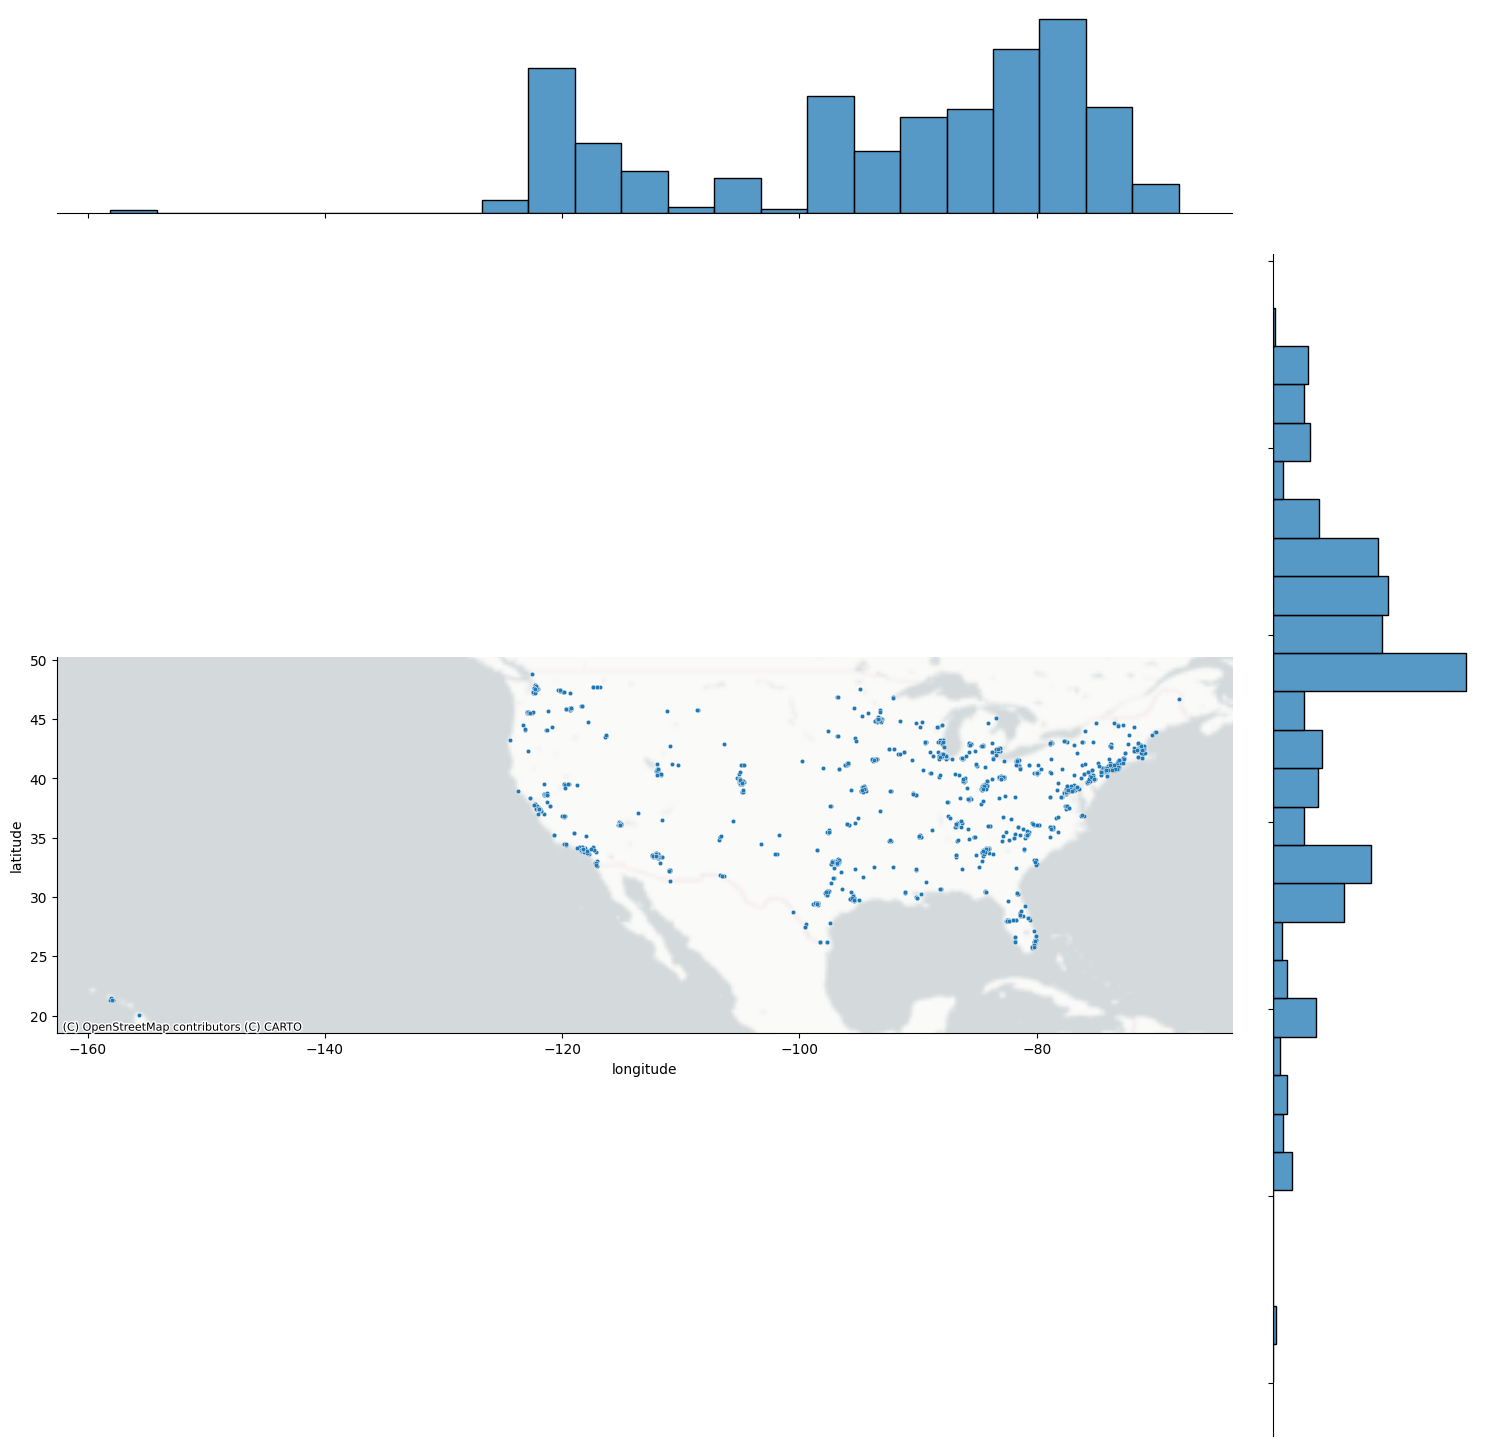

In [9]:
# Generate scatter plot
joint_axes = seaborn.jointplot(height=15,
    x="longitude", y="latitude", data=dc_gdf, s=10
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
);

In [11]:
def kde_plot(df):
    # Set up figure and axis
    f, ax = plt.subplots(1, figsize=(20, 20))

    # Generate and add KDE with a shading of 50 gradients, coloured contours, 75% of transparency,
    # and the reverse viridis colormap
    seaborn.kdeplot(
        x="longitude",
        y="latitude",
        data=df,
        n_levels=100,
        fill=True,
        alpha=0.4,
        cmap="viridis_r",
        ax=ax
    )

    # Add the points themselves to the plot
    ax.scatter(
        df['longitude'],
        df['latitude'],
        s=5,  # Size of points
        c='red',  # Color of points
        alpha=0.3  # Transparency of points
    )

    # Add basemap
    contextily.add_basemap(
        ax=ax,
        crs="EPSG:4326",
        source=contextily.providers.CartoDB.PositronNoLabels,
    )

    # Remove axes
    ax.set_axis_off()

    # Display the plot
    plt.show()


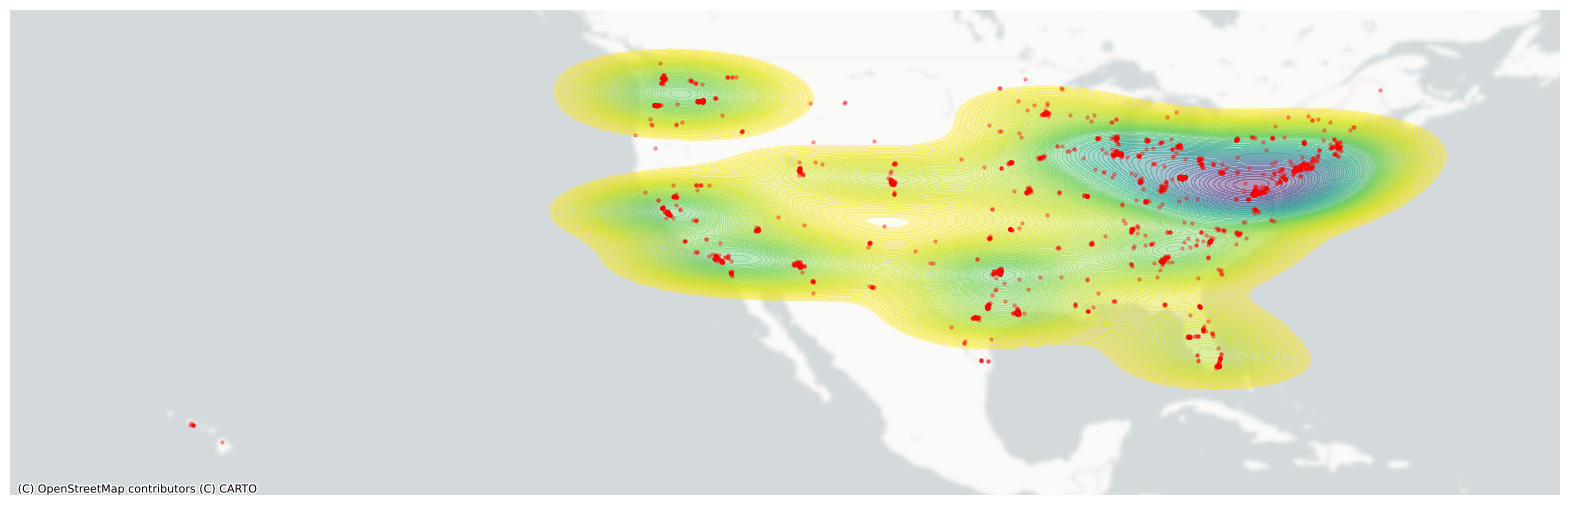

In [12]:
kde_plot(dc_gdf)

#  Ripley G function

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pointpats import distance_statistics

In [ ]:
# Load your data
data_file = os.path.join('..', 'in', 'datacenters_usa_clean.csv')

#where to save data
out_path = os.path.join('..', 'out')

dc_df = pd.read_csv(data_file)

In [ ]:
def remove_nan_rows(df, lat_column='latitude', lon_column='longitude'):
    """
    Remove rows with NaN values in specified latitude and longitude columns from a dataframe.
    
    Parameters:
    - df: pandas DataFrame
        The dataframe containing latitude and longitude columns.
    - lat_column: str, optional (default='latitude')
        Name of the latitude column.
    - lon_column: str, optional (default='longitude')
        Name of the longitude column.
    
    Returns:
    - df_cleaned: pandas DataFrame
        DataFrame with rows containing NaN values in latitude or longitude columns removed.
    """
    # Check for NaN values in specified columns
    nan_mask = df[[lat_column, lon_column]].isnull().any(axis=1)
    
    # Remove rows with NaN values
    df_cleaned = df[~nan_mask]
    
    return df_cleaned

In [ ]:
dc_df = remove_nan_rows(dc_df)

2526

### Compute Ripley G
Below we create a custom function to pass a dataframe into, along iwth the columns for latitude an longitude.

The function extracts the coordinates from the lat & long columns, and using those data center coordinates, runs a specified amount of simulations, which is known as a "G_test". This means we run N amount of simulations, and 

We can also optionally specify how many simulations to run (default=9999 simulations. Took about 5 minutes to compute on own hardware). Decrease amount of simulations to speed up computation.

In [ ]:
def compute_ripley_g(df, lat_column, long_column, detail=100, simulations=9999):
    # Extract coordinates from latitude and longitude columns
    coordinates = df[[lat_column, long_column]].values

    #perform a g_test on the extracted coordinates
    g_test = distance_statistics.g_test(
        coordinates, support=detail, keep_simulations=True, n_simulations=simulations
    )
    return g_test, coordinates

In [ ]:
#compute a ripley g test, by performing 9999 simulations. 
g_test, coordinates = compute_ripley_g(dc_df, 'latitude', 'longitude', simulations=9999)

In [ ]:
def plot_ripley(coordinates, test, type, xlim=False, save_filename=None):
    # Plotting
    f, ax = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3)))

    # Plot simulations with fine lines
    ax[0].plot(test.support, test.simulations.T, color="k", alpha=0.01)

    # Plot median of simulations
    ax[0].plot(test.support, np.median(test.simulations, axis=0), color="cyan", label="median simulation")

    # Plot observed pattern's F function
    ax[0].plot(test.support, test.statistic, label="observed", color="red")

    # Labeling and formatting
    ax[0].set_xlabel("Distance")
    ax[0].set_ylabel("% of nearest point in pattern\ndistances shorter")
    ax[0].legend()
    if xlim:
        ax[0].set_xlim(0, xlim)
    ax[0].set_title(f"Ripley's ${type}(d)$ function")

    # Plot the data points themselves
    #coordinates[:, 1] = longitude
    #coordinates[:, 0] = latitude
    #s = size of points
    ax[1].scatter(coordinates[:, 1], coordinates[:, 0], s=1)

    # Formatting the plot of the pattern
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
    ax[1].set_title("Pattern")

    # Adjust layout and display
    f.tight_layout()
    
    # Optionally save the plot
    if save_filename:
        plt.savefig(os.path.join(out_path, save_filename))
    
    plt.show()

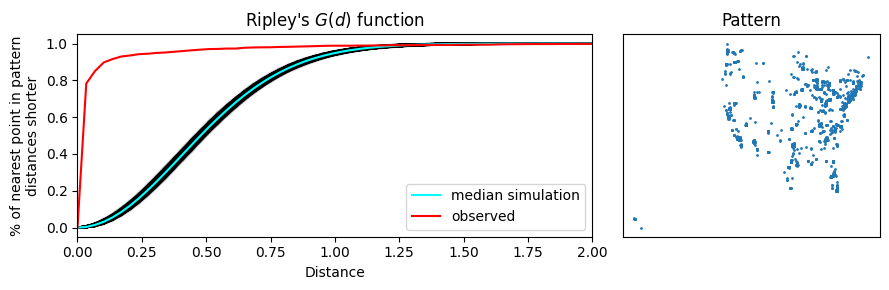

In [ ]:
plot_ripley(coordinates, g_test, 'G', xlim=2, save_filename='Ripley G plot.png')